# Time Series Classification

## Import modules and set path.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


PATH='/Users/nicholashedger/Documents/GitHub/NH_EYETRACK_NOODLE'

## Load in files.

In [3]:
def load_data(PATH,FILE):
	csvpath=os.path.join(PATH,FILE)
	return pd.read_csv(csvpath)


TIMESERIES=load_data(PATH,'timeseries.csv') # The full timeseries data.
SCRAMLAB=load_data(PATH,'sclabels.csv') # The labels corresponding to whether the trial was scrambled or not.
SIDETIMESERIES=load_data(PATH,'timeseriesside.csv') # The timeseries for intact images only
SIDELAB=load_data(PATH,'sidelabels.csv') # The labels corresponding to the location of the social image.

In [4]:
TIMESERIES.shape

(3078000, 6)

In [5]:
SCRAMLAB.shape

(6156, 2)

In [6]:
SIDELAB.shape

(3080, 2)

The side data is half the size, since it is only based on intact trials.

In [7]:
TIMESERIES.head()

,Unnamed: 0,id,time,X,Y,ps
0,1,1,0.00000,762.3,639.5,1
1,2,1,10.02004,762.3,639.5,1
2,3,1,20.04008,762.3,639.5,1
3,4,1,30.06012,762.3,639.5,1
4,5,1,40.08016,762.3,639.5,1


In TIMESERIES data are re-structured so that id codes the timeseries, time codes the timepoint and X and Y are the coordinates.

In [8]:
SCRAMLAB.head()

,Unnamed: 0,sc
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


SCRAMLAB and SIDELAB just code the labels to be classified (1 per timeseries). Plot an example timeseries instance.

In [33]:
def tsplot(FRAME,id):
    instance=FRAME[(FRAME["id"]==id)]
    plt.plot(instance["X"],instance["Y"])
    plt.show

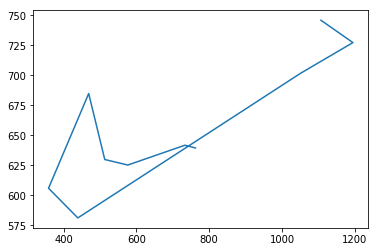

In [34]:
x=tsplot(TIMESERIES,1) # Plot the Y coordinate for the first timeseries.

In [11]:
# Drop columns not required.
TIMESERIES=TIMESERIES.drop('Unnamed: 0',1)
SIDETIMESERIES=SIDETIMESERIES.drop('Unnamed: 0',1)
SCRAMLAB=SCRAMLAB.drop('Unnamed: 0',1)
SIDELAB=SIDELAB.drop('Unnamed: 0',1)
TIMESERIES=TIMESERIES.drop('ps',1)
SIDETIMESERIES=SIDETIMESERIES.drop('ps',1)

## Classifcation of intact versus scrambled images

In [12]:
# Re-structure labels into a 1D numpy array
LABELS=SCRAMLAB
LABELSPREP=pd.DataFrame.as_matrix(LABELS)
LABELSPREP=np.squeeze(LABELSPREP)

In [13]:
LABELSPREP.shape

(6156,)

In [14]:
from tsfresh import extract_relevant_features

/Users/nicholashedger/anaconda2/envs/env/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
features_filtered_direct = extract_relevant_features(TIMESERIES, LABELSPREP,
                                                     column_id='id', column_sort='time')

Feature Extraction: 10it [1:46:46, 640.69s/it]                       
 'X__friedrich_coefficients__m_3__r_30__coeff_1'
 'X__friedrich_coefficients__m_3__r_30__coeff_2'
 'X__friedrich_coefficients__m_3__r_30__coeff_3'
 'X__max_langevin_fixed_point__m_3__r_30'
 'Y__friedrich_coefficients__m_3__r_30__coeff_0'
 'Y__friedrich_coefficients__m_3__r_30__coeff_1'
 'Y__friedrich_coefficients__m_3__r_30__coeff_2'
 'Y__friedrich_coefficients__m_3__r_30__coeff_3'
 'Y__max_langevin_fixed_point__m_3__r_30'] did not have any finite values. Filling with zeros.


In [16]:
features_filtered_direct.head()
# Dump the data. 
import dill                            
filename = 'T_S_dump.pkl'
dill.dump_session(filename)

Scale all of the data. 

In [19]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
trans=scaler.fit(features_filtered_direct)
scaled=scaler.transform(features_filtered_direct)
scaled.shape


(6156, 518)

Split the data into a training and test set.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(scaled, LABELSPREP, test_size=.2)


Fit a random forest classifier. Perform a cross validation and list the features in order of importance.

In [21]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier() 
cl.fit(X_train, y_train) # Fit to the training data

scoreCV=cross_val_score(cl,X_train,y_train,cv=10,scoring='accuracy') # Cross validate.

from sklearn.metrics import classification_report # Show performance at classifying the test data
print(classification_report(y_test, cl.predict(X_test)))

# Show the most important features (refer to pd frame since standardscaler forced this to be a numpy object.
attributes=list(features_filtered_direct) 

sorted(zip(cl.feature_importances_,attributes),reverse=True)

             precision    recall  f1-score   support

          1       0.68      0.76      0.72       613
          2       0.73      0.64      0.68       619

avg / total       0.70      0.70      0.70      1232



[(0.015379046973361371, 'Y__ratio_value_number_to_time_series_length'),
 (0.015162751368423089,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20'),
 (0.012988899745742449, 'X__binned_entropy__max_bins_10'),
 (0.011192570669156502,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_1__w_20'),
 (0.010134402964271837,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_2__w_20'),
 (0.0095503756766183341, 'X__quantile__q_0.2'),
 (0.0086296476682444258, 'Y__approximate_entropy__m_2__r_0.1'),
 (0.0084728500104411346,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_10__w_10'),
 (0.0084094057022015174,
  'X__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_5__w_20'),
 (0.0078122439622058211, 'X__approximate_entropy__m_2__r_0.5'),
 (0.0077991292168097023, 'X__sample_entropy'),
 (0.0077781627552969534, 'X__approximate_entropy__m_2__r_0.7'),
 (0.0075662757175081492, 'X__quantile__q_0.4'),
 (0.0067417476275334664, 'Y__approximate_entropy__m_2__r_0.5'),
 (0.0065925178992762828, 'Y

To visualise the most important features, find the instances with the minimum and maximum of these values and plot them.

In [36]:
features_filtered_direct['Y__ratio_value_number_to_time_series_length'].idxmin()

1303

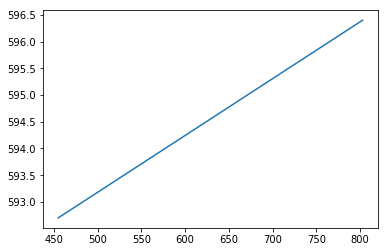

In [37]:
x=tsplot(TIMESERIES,1303)

Now create a new feature matrix using the top k features.

In [25]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


top_k=indices_of_top_k(cl.feature_importances_,10)

toplabels=np.array(attributes)[top_k]

topkmat=np.array(features_filtered_direct)[:,top_k]


X_train, X_test, y_train, y_test = train_test_split(topkmat, LABELSPREP, test_size=.2)

from sklearn.ensemble import RandomForestClassifier

cl2 = RandomForestClassifier()
cl2.fit(X_train, y_train)

scoreCV2=cross_val_score(cl2,X_train,y_train,cv=10,scoring='accuracy')


In [26]:
scoreCV2

array([ 0.68825911,  0.6673428 ,  0.69979716,  0.71341463,  0.68495935,
        0.71138211,  0.73780488,  0.72154472,  0.73170732,  0.71138211])

In [ ]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 60, 120], 'max_features': [2, 4, 6, 8, 10]}]



from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(cl2, param_grid, cv=5,scoring='accuracy')

grid_search.fit(X_train, y_train)



cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))


In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_estimator_.feature_importances_

In [ ]:
toplabels